# Google Analytics Customer Revenue Prediction

### Group Members
* Zili Bu
* Hsin-Yu Chen
* Kexin Zhang
* Huang-Chin Ye

### Executive Summary

### Introduction
* What dataset you used and your initial plan

We found Google Analytics Customer Revenue Prediction dataset from Kaggle. Our initial plan is to clean the dataset, explore the dataset by plots, use spark sql to do further analysis to get an insight about user behaviors. 

### Exploratory analysis section
* Any insights you've learned from the data (with charts to illustrate)

In [1]:
# import needed libraries
import pandas as pd
import numpy as np

In [56]:
import findspark
findspark.init()

In [57]:
from pyspark import SparkContext
sc = SparkContext()

In [58]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
spark = SparkSession.builder.appName("Project-DNSC6290").getOrCreate()

In [2]:
from time import time

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import json # to convert json in df
from pandas.io.json import json_normalize # to normalize the json file
import os # it's a operational system library, to set some informations

## Convert Json Columns

In [4]:
#dir_path = "/Users/hyen86/BigData/Project/"
def load_df(df, nrows = None):
    #Columns that have json format
    json_columns = ['device', 'geoNetwork', 'totals', 'trafficSource']
    #nrows = None
    
    df = pd.read_csv(df, 
                converters={column: json.loads for column in json_columns}, 
                dtype={'fullVisitorId': 'str'}, # Important!!
                nrows=nrows)
    
    for column in json_columns:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Shape: {df.shape}")
    return df

In [5]:
#check load_df running time
start_time = time()
data = load_df("train_v2.csv")
end_time = time()
time_taken = end_time - start_time
time_taken

Shape: (1708337, 60)


1029.949017047882

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 60 columns):
channelGrouping                                      object
customDimensions                                     object
date                                                 int64
fullVisitorId                                        object
hits                                                 object
socialEngagementType                                 object
visitId                                              int64
visitNumber                                          int64
visitStartTime                                       int64
device.browser                                       object
device.browserVersion                                object
device.browserSize                                   object
device.operatingSystem                               object
device.operatingSystemVersion                        object
device.isMobile                                    

In [7]:
data.to_csv('load_df_data.csv', index=False)

In [9]:
# data_v2 = pd.read_csv('load_df_data.csv')

In [10]:
# data_v2.info()

In [11]:
# Check missing values fro each column
def missing_values(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum() / data.isnull().count() * 100 ).sort_values(ascending = False)
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print("Total columns at least one Values: ")
    print(df.loc[df['Total'] >0])
    return

In [12]:
missing_values(data)

Total columns at least one Values: 
                                                Total    Percent
trafficSource.campaignCode                    1708336  99.999941
totals.totalTransactionRevenue                1689823  98.916256
totals.transactionRevenue                     1689823  98.916256
totals.transactions                           1689778  98.913622
trafficSource.adContent                       1643600  96.210525
trafficSource.adwordsClickInfo.adNetworkType  1633063  95.593727
trafficSource.adwordsClickInfo.slot           1633063  95.593727
trafficSource.adwordsClickInfo.page           1633063  95.593727
trafficSource.adwordsClickInfo.isVideoAd      1633063  95.593727
trafficSource.adwordsClickInfo.gclId          1632914  95.585005
trafficSource.isTrueDirect                    1173819  68.711209
trafficSource.referralPath                    1142073  66.852910
trafficSource.keyword                         1052780  61.626014
totals.timeOnSite                              874294 

In [32]:
for item in list(data.columns):
    print(list(data.columns).index(item), item)

0 channelGrouping
1 customDimensions
2 date
3 fullVisitorId
4 hits
5 socialEngagementType
6 visitId
7 visitNumber
8 visitStartTime
9 device.browser
10 device.browserVersion
11 device.browserSize
12 device.operatingSystem
13 device.operatingSystemVersion
14 device.isMobile
15 device.mobileDeviceBranding
16 device.mobileDeviceModel
17 device.mobileInputSelector
18 device.mobileDeviceInfo
19 device.mobileDeviceMarketingName
20 device.flashVersion
21 device.language
22 device.screenColors
23 device.screenResolution
24 device.deviceCategory
25 geoNetwork.continent
26 geoNetwork.subContinent
27 geoNetwork.country
28 geoNetwork.region
29 geoNetwork.metro
30 geoNetwork.city
31 geoNetwork.cityId
32 geoNetwork.networkDomain
33 geoNetwork.latitude
34 geoNetwork.longitude
35 geoNetwork.networkLocation
36 totals.visits
37 totals.hits
38 totals.pageviews
39 totals.bounces
40 totals.newVisits
41 totals.sessionQualityDim
42 totals.timeOnSite
43 totals.transactions
44 totals.transactionRevenue
45 total

From above function, we can see some columns are having a lot of null values. Therefore, we deceided to drop all columns that have around or above 50% null vlaue. We drop all the trafficSource related columns.

In [33]:
# We dropped 17 columns
dataNew = data.drop(data.columns[[1, 4, 39, 41, 42, 43, 45, 49, 52, 51, 53, 54, 55, 56, 57, 58 ,59]], axis=1)

In [34]:
dataNew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 43 columns):
channelGrouping                                      object
date                                                 int64
fullVisitorId                                        object
socialEngagementType                                 object
visitId                                              int64
visitNumber                                          int64
visitStartTime                                       int64
device.browser                                       object
device.browserVersion                                object
device.browserSize                                   object
device.operatingSystem                               object
device.operatingSystemVersion                        object
device.isMobile                                      bool
device.mobileDeviceBranding                          object
device.mobileDeviceModel                             

In [35]:
data_constCol = [c for c in dataNew.columns if dataNew[c].nunique()==1]

In [36]:
data_constCol

['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'totals.newVisits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

From above code, we find these columns are all having one constant value, which are not informative for our analysis. We may consider to drop them.

In [37]:
dataNew2 = dataNew.drop(dataNew[data_constCol], axis=1)

In [38]:
dataNew2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 23 columns):
channelGrouping              object
date                         int64
fullVisitorId                object
visitId                      int64
visitNumber                  int64
visitStartTime               int64
device.browser               object
device.operatingSystem       object
device.isMobile              bool
device.deviceCategory        object
geoNetwork.continent         object
geoNetwork.subContinent      object
geoNetwork.country           object
geoNetwork.region            object
geoNetwork.metro             object
geoNetwork.city              object
geoNetwork.networkDomain     object
totals.hits                  object
totals.pageviews             object
totals.transactionRevenue    object
trafficSource.campaign       object
trafficSource.source         object
trafficSource.medium         object
dtypes: bool(1), int64(4), object(18)
memory usage: 288.4+ MB


### Creating the function to handle with date

In [42]:
# library of datetime
from datetime import datetime

# This function is to extract date features
def date_process(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # seting the column as pandas datetime
    df["weekday"] = df['date'].dt.weekday #extracting week day
    df["day"] = df['date'].dt.day # extracting day
    df["month"] = df['date'].dt.month # extracting day
    df["year"] = df['date'].dt.year # extracting day
    df["visitHour"] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
    
    return df #returning the df after the transformations

In [43]:
dataNew2 = date_process(dataNew2)

In [44]:
dataNew2.head(5)

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,...,_weekday,_day,_month,_year,_visitHour,weekday,day,month,year,visitHour
0,Organic Search,2017-10-16,3162355547410993243,1508198450,1,1508198450,Firefox,Windows,False,desktop,...,0,16,10,2017,20,0,16,10,2017,20
1,Referral,2017-10-16,8934116514970143966,1508176307,6,1508176307,Chrome,Chrome OS,False,desktop,...,0,16,10,2017,13,0,16,10,2017,13
2,Direct,2017-10-16,7992466427990357681,1508201613,1,1508201613,Chrome,Android,True,mobile,...,0,16,10,2017,20,0,16,10,2017,20
3,Organic Search,2017-10-16,9075655783635761930,1508169851,1,1508169851,Chrome,Windows,False,desktop,...,0,16,10,2017,12,0,16,10,2017,12
4,Organic Search,2017-10-16,6960673291025684308,1508190552,1,1508190552,Chrome,Windows,False,desktop,...,0,16,10,2017,17,0,16,10,2017,17


In [49]:
# dataNew2 = dataNew2.drop(['_weekday', '_day', '_month', '_year', '_visitHour'], axis=1)

In [50]:
dataNew2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 28 columns):
channelGrouping              object
date                         datetime64[ns]
fullVisitorId                object
visitId                      int64
visitNumber                  int64
visitStartTime               int64
device.browser               object
device.operatingSystem       object
device.isMobile              bool
device.deviceCategory        object
geoNetwork.continent         object
geoNetwork.subContinent      object
geoNetwork.country           object
geoNetwork.region            object
geoNetwork.metro             object
geoNetwork.city              object
geoNetwork.networkDomain     object
totals.hits                  object
totals.pageviews             object
totals.transactionRevenue    object
trafficSource.campaign       object
trafficSource.source         object
trafficSource.medium         object
weekday                      int64
day                  

### Convert the str in totals.* columns to the proper format.

In [51]:
dataNew2["totals.transactionRevenue"] = dataNew2["totals.transactionRevenue"].astype('float')
dataNew2["totals.hits"] = dataNew2["totals.hits"].astype('float')
dataNew2["totals.pageviews"] = dataNew2["totals.pageviews"].astype('float')
#convert the datetype of revenue to float format

In [52]:
dataNew2["totals.transactionRevenue"].fillna(0, inplace=True) # fill all the rows with N/A in transctions with 0
dataNew2["totals.transactionRevenue"].isna().sum() # Now, it should have 0 N/A value

0

In [53]:
dataNew2["totals.hits"].isna().sum()# check N/A value in total.hits

0

In [54]:
dataNew2["totals.pageviews"].fillna(0, inplace=True)# fill all the rows with N/A in transctions with 0
dataNew2["totals.pageviews"].isna().sum()# Now, it should have 0 N/A value

0

In [61]:
dataNew2.to_csv('data_clean.csv', index=False)

## EDA

### Create Spark Dataframe

In [115]:
sparkDF = spark.read\
    .format('csv')\
    .option('header', 'true')\
    .option('inferSchema', 'true')\
    .load('s3://largedataset-project/data_clean.csv')

Py4JJavaError: An error occurred while calling o37.load.
: org.apache.hadoop.fs.UnsupportedFileSystemException: No FileSystem for scheme "s3"
	at org.apache.hadoop.fs.FileSystem.getFileSystemClass(FileSystem.java:3281)
	at org.apache.hadoop.fs.FileSystem.createFileSystem(FileSystem.java:3301)
	at org.apache.hadoop.fs.FileSystem.access$200(FileSystem.java:124)
	at org.apache.hadoop.fs.FileSystem$Cache.getInternal(FileSystem.java:3352)
	at org.apache.hadoop.fs.FileSystem$Cache.get(FileSystem.java:3320)
	at org.apache.hadoop.fs.FileSystem.get(FileSystem.java:479)
	at org.apache.hadoop.fs.Path.getFileSystem(Path.java:361)
	at org.apache.spark.sql.execution.streaming.FileStreamSink$.hasMetadata(FileStreamSink.scala:46)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:361)
	at org.apache.spark.sql.DataFrameReader.loadV1Source(DataFrameReader.scala:279)
	at org.apache.spark.sql.DataFrameReader.$anonfun$load$2(DataFrameReader.scala:268)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:268)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:214)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:564)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:832)


In [ ]:
sparkDF.printSchema()

In [ ]:
sparkDF.cache()

In [ ]:
sparkDF.createOrReplaceTempView('viewDF')

### Visit Counts

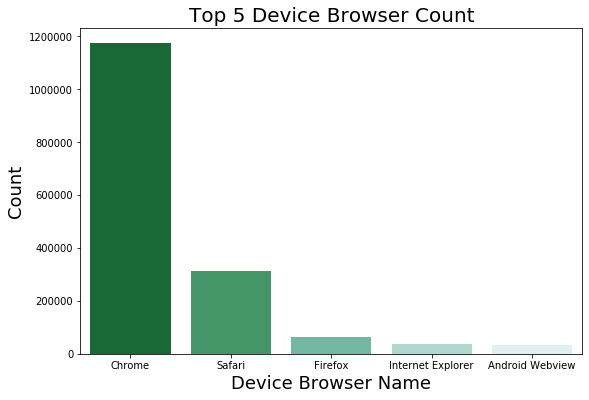

In [63]:
# seting the graph size
plt.figure(figsize=(9,6))
browser_order = dataNew2["device.browser"].value_counts()[:5].sort_values(ascending=False).index

# let explore the browser used by users
sns.countplot(dataNew2["device.browser"], order=browser_order, palette='BuGn_r')
plt.title("Top 5 Device Browser Count", fontsize=20) # seting the title size
plt.xlabel("Device Browser Name", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show()

In [ ]:
# Top 5 Device Browser Count
spark.sql("""SELECT `device.browser`, COUNT(`device.browser`) AS Count \
            FROM viewDF \
            GROUP BY `device.browser` \
            ORDER BY COUNT(`device.browser`) DESC \
            LIMIT 5""").show()

The top 5 browsers are Chrome, Safari, Firefox, Internet Explorer, and Android Webview

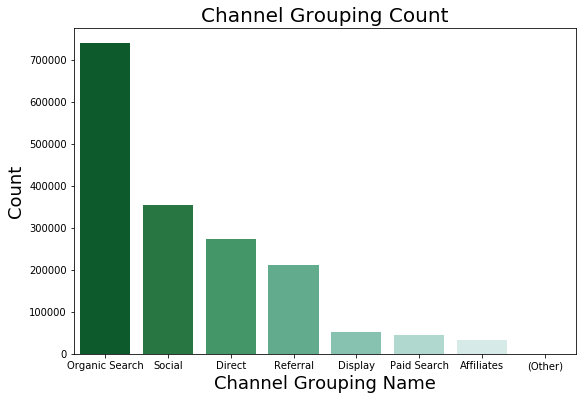

In [65]:
# seting the graph size
plt.figure(figsize=(9,6))
channel_order = dataNew2["channelGrouping"].value_counts().sort_values(ascending=False).index

sns.countplot(dataNew2["channelGrouping"], order=channel_order, palette='BuGn_r')
#Paired, Set2, hls
plt.title("Channel Grouping Count", fontsize=20) # seting the title size
plt.xlabel("Channel Grouping Name", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show()

In [ ]:
#Channel Grouping Count
spark.sql(""" SELECT channelGrouping, COUNT(channelGrouping) AS Count 
          FROM viewDF 
          GROUP BY channelGrouping 
          ORDER BY COUNT(channelGrouping) DESC """).show()

After counting the channel, we can see user used the Organic Search the most. Next are Social, Direct, and Referral.

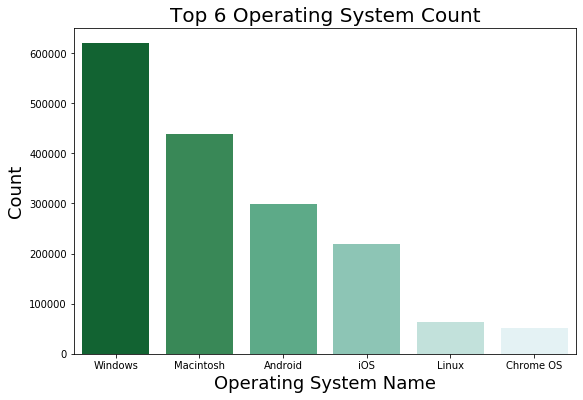

In [66]:
# Top 6 Operating System Count
plt.figure(figsize=(9,6))
operatingSystem_order = dataNew2["device.operatingSystem"].value_counts()[:6].sort_values(ascending=False).index

sns.countplot(dataNew2["device.operatingSystem"], order=operatingSystem_order, palette='BuGn_r')
plt.title("Top 6 Operating System Count", fontsize=20) # seting the title size
plt.xlabel("Operating System Name", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show()

In [ ]:
# Top 6 Operating System Count
spark.sql("""SELECT `device.operatingSystem`, COUNT(`device.operatingSystem`) AS Count \
            FROM viewDF \
            GROUP BY `device.operatingSystem` \
            ORDER BY COUNT(`device.operatingSystem`) DESC \
            LIMIT 6""").show()

Top 6 operating systems are Windows, Macintosh, Android, iOS, Linux, Chrome OS

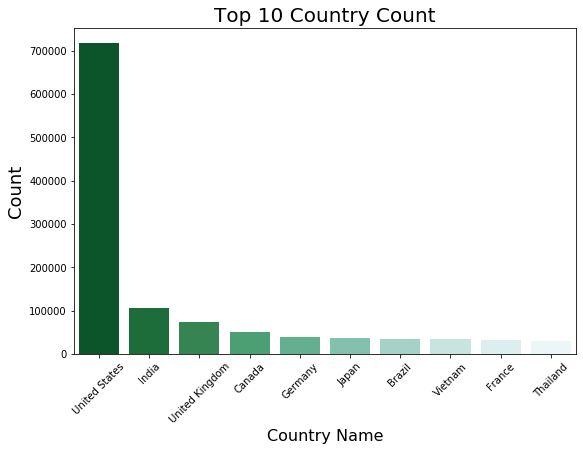

In [72]:
# Top 10 Country Count
plt.figure(figsize=(9,6))
country_order = dataNew2["geoNetwork.country"].value_counts()[:10].sort_values(ascending=False).index

sns.countplot(dataNew2["geoNetwork.country"], order=country_order, palette='BuGn_r')
plt.title("Top 10 Country Count", fontsize=20) # seting the title size
plt.xlabel("Country Name", fontsize=16) # seting the x label size
plt.xticks(rotation=45)
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show()

In [ ]:
# Top 10 Country Count
spark.sql("""SELECT `geoNetwork.country`, COUNT(`geoNetwork.country`) AS Count \
            FROM viewDF \
            GROUP BY `geoNetwork.country` \
            ORDER BY COUNT(`geoNetwork.country`) DESC\
            LIMIT 10""").show()

Top 10 countries that users come from are United States, India, United Kingdom, Canada, Vietnam, Turkey, Thailand, Germany, Brazil, and Japan

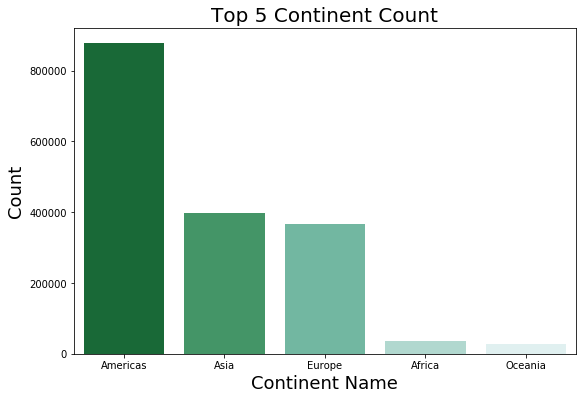

In [73]:
# Top 5 Continent Count
plt.figure(figsize=(9,6))
continent_order = dataNew2["geoNetwork.continent"].value_counts()[:5].sort_values(ascending=False).index

sns.countplot(dataNew2["geoNetwork.continent"], order=continent_order, palette='BuGn_r')
plt.title("Top 5 Continent Count", fontsize=20) # seting the title size
plt.xlabel("Continent Name", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show()

In [ ]:
# Top 5 Continent Count
spark.sql("""SELECT `geoNetwork.continent`, COUNT(`geoNetwork.continent`) AS Count \
            FROM viewDF \
            GROUP BY `geoNetwork.continent` \
            ORDER BY COUNT(`geoNetwork.continent`) DESC\
            LIMIT 5""").show()

Americas is the first Continent that has the most traffic. Oceania has the least traffic.

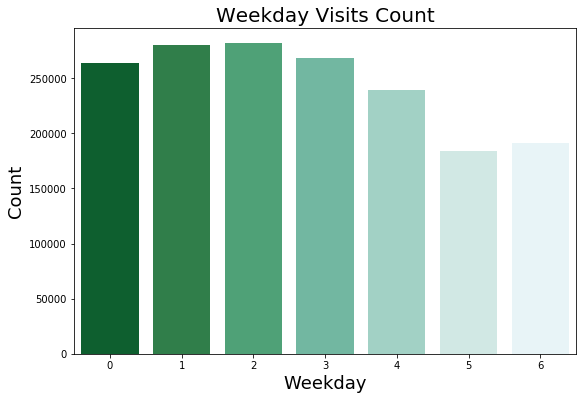

In [74]:
# Weekday Visits Count
plt.figure(figsize=(9,6))

sns.countplot(dataNew2["weekday"], palette='BuGn_r')
plt.title("Weekday Visits Count", fontsize=20) # seting the title size
plt.xlabel("Weekday", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show()

In [ ]:
# Weekday Visits Count
spark.sql("""SELECT weekday, COUNT(weekday) AS Count \
            FROM viewDF \
            GROUP BY weekday \
            ORDER BY weekday\
            LIMIT 7""").show()

Monday, Tuesday,  Wednesday are top 3 weekdays that have the most vist. Surprisingly, weekends contributed the least visits. 

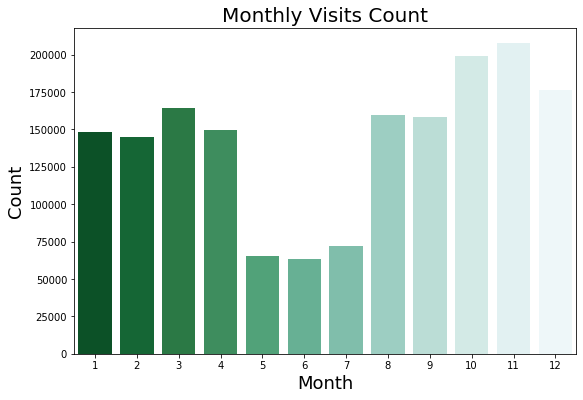

In [75]:
#Monthly Visits Count
plt.figure(figsize=(9,6))

sns.countplot(dataNew2["month"], palette='BuGn_r')
plt.title("Monthly Visits Count", fontsize=20) # seting the title size
plt.xlabel("Month", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show()

In [ ]:
# Monthly Visits Count
spark.sql("""SELECT month, COUNT(month) AS Count \
            FROM viewDF \
            GROUP BY month \
            ORDER BY month\
            LIMIT 12""").show()

October and November have the most visits, while May, June, and July have the least.

### Transactions

In [91]:
# Find number of rows that totals.transactionRevenue is nonzero
np.count_nonzero(dataNew2["totals.transactionRevenue"])

18514

In [92]:
# Find the ratio of nonzero rows above the entire dataset
nz_revenue= np.count_nonzero(dataNew2["totals.transactionRevenue"])
print(f"The number of non-zero transaction is {nz_revenue} \nThe ratio is {nz_revenue/dataNew2.shape[0]}")

The number of non-zero transaction is 18514 
The ratio is 0.010837440153786987


In [89]:
nz_revenue_df = dataNew2.loc[dataNew2["totals.transactionRevenue"]>0] #create a new df with only non-zero transactions
nz_revenue_df.head(5)

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,...,totals.pageviews,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,weekday,day,month,year,visitHour
433,Organic Search,2017-10-16,9549826748224805897,1508200705,4,1508200705,Chrome,Macintosh,False,desktop,...,9.0,15190000.0,(not set),google,organic,0,16,10,2017,20
550,Referral,2017-10-16,3700714855829972615,1508192636,11,1508192636,Chrome,Windows,False,desktop,...,12.0,8000000.0,(not set),(direct),(none),0,16,10,2017,18
555,Organic Search,2017-10-16,1572225825161580042,1508162218,6,1508162218,Safari,iOS,True,mobile,...,15.0,57300000.0,(not set),google,organic,0,16,10,2017,9
597,Referral,2017-10-16,7187192533100162289,1508189401,17,1508189401,Chrome,Macintosh,False,desktop,...,16.0,18230000.0,(not set),(direct),(none),0,16,10,2017,17
619,Referral,2017-10-16,7889233516776348524,1508190484,1,1508190484,Chrome,Macintosh,False,desktop,...,20.0,12310000.0,(not set),(direct),(none),0,16,10,2017,17


In [90]:
nz_revenue_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18514 entries, 433 to 1708001
Data columns (total 28 columns):
channelGrouping              18514 non-null object
date                         18514 non-null datetime64[ns]
fullVisitorId                18514 non-null object
visitId                      18514 non-null int64
visitNumber                  18514 non-null int64
visitStartTime               18514 non-null int64
device.browser               18514 non-null object
device.operatingSystem       18514 non-null object
device.isMobile              18514 non-null bool
device.deviceCategory        18514 non-null object
geoNetwork.continent         18514 non-null object
geoNetwork.subContinent      18514 non-null object
geoNetwork.country           18514 non-null object
geoNetwork.region            18514 non-null object
geoNetwork.metro             18514 non-null object
geoNetwork.city              18514 non-null object
geoNetwork.networkDomain     18514 non-null object
totals.hits      

### Total Hits

<function matplotlib.pyplot.show(*args, **kw)>

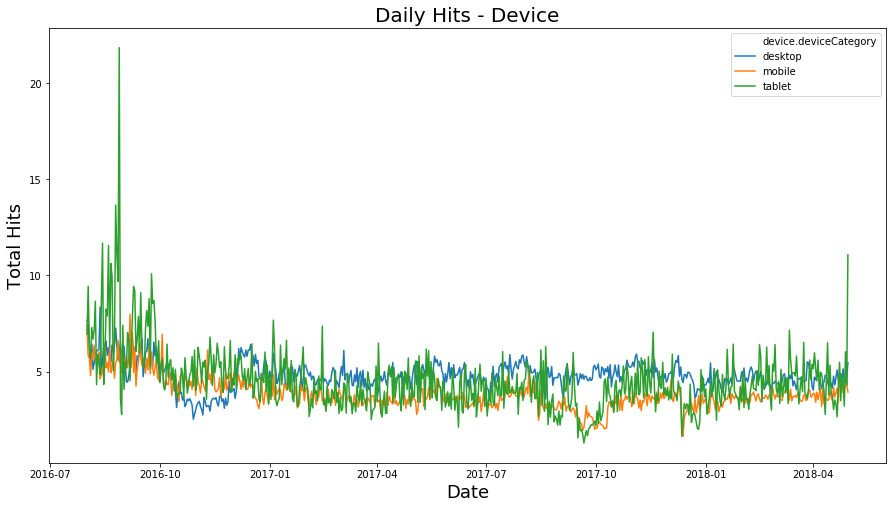

In [98]:
# Daily Hits
plt.figure(figsize=(15,8))
sns.lineplot(x="date", y="totals.hits", data=dataNew2, ci=None, hue="device.deviceCategory")
plt.title("Daily Hits - Device", fontsize=20)
plt.xlabel("Date", fontsize=18) 
plt.ylabel("Total Hits", fontsize=18)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

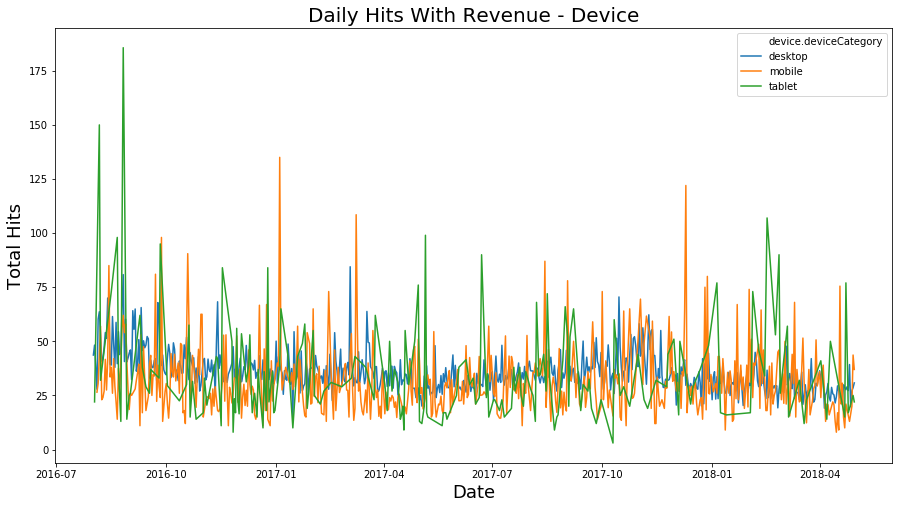

In [99]:
# Total Hits Across the Date with Nonzero Revenue
plt.figure(figsize=(15,8))
sns.lineplot(x="date", y="totals.hits", data=nz_revenue_df, ci=None, hue="device.deviceCategory")
plt.title("Daily Hits With Revenue - Device", fontsize=20)
plt.xlabel("Date", fontsize=18) 
plt.ylabel("Total Hits", fontsize=18)
plt.show

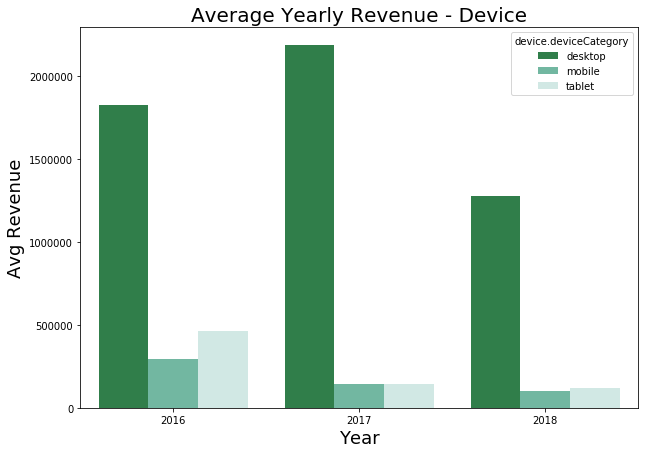

In [100]:
# Average Yearly Revenue - Device
plt.figure(figsize=(10,7))

sns.barplot(x="year", y="totals.transactionRevenue", hue="device.deviceCategory", data=dataNew2, palette='BuGn_r', ci=None)
plt.title("Average Yearly Revenue - Device", fontsize=20) # seting the title size
plt.xlabel("Year", fontsize=18) # seting the x label size
plt.ylabel("Avg Revenue", fontsize=18) # seting the y label size

plt.show()

In [ ]:
# Average Yearly Revenue - Device
spark.sql("""SELECT year, `device.deviceCategory`, ROUND(AVG(`totals.transactionRevenue`),2) as AvgRevenue \
             FROM viewDF \
             GROUP BY `device.deviceCategory`, year\
             ORDER BY year, AVG(`totals.transactionRevenue`)
             """).show()

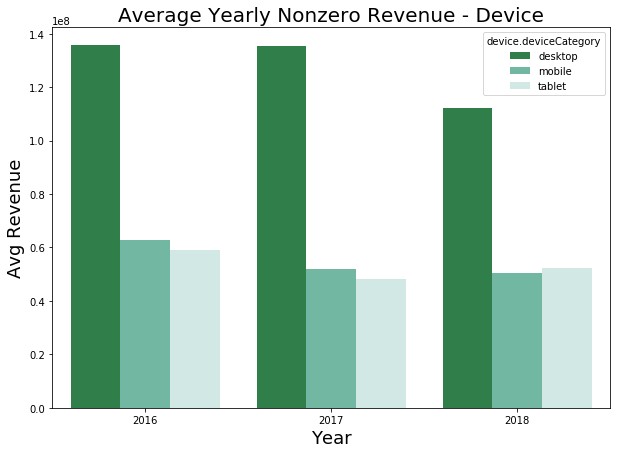

In [101]:
# Average Yearly Nonzero Revenue - Device
plt.figure(figsize=(10,7))

sns.barplot(x="year", y="totals.transactionRevenue", hue="device.deviceCategory", data=nz_revenue_df, palette='BuGn_r', ci=None)
plt.title("Average Yearly Nonzero Revenue - Device", fontsize=20) # seting the title size
plt.xlabel("Year", fontsize=18) # seting the x label size
plt.ylabel("Avg Revenue", fontsize=18) # seting the y label size

plt.show()

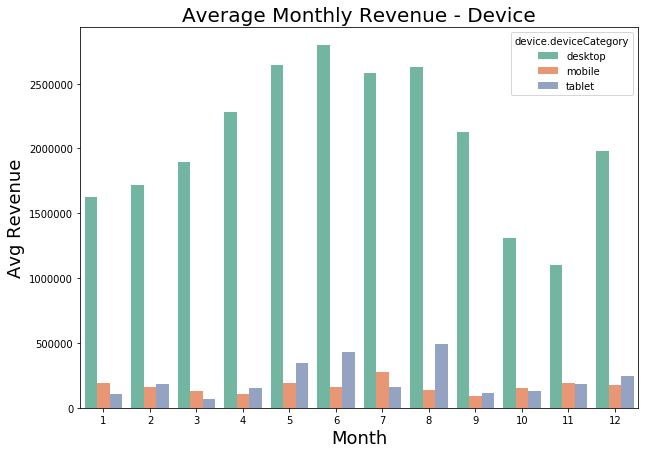

In [102]:
#Average Monthly Revenue - Device
plt.figure(figsize=(10,7))

sns.barplot(x="month", y="totals.transactionRevenue", hue="device.deviceCategory", data=dataNew2, palette='Set2', ci=None)
plt.title("Average Monthly Revenue - Device", fontsize=20) # seting the title size
plt.xlabel("Month", fontsize=18) # seting the x label size
plt.ylabel("Avg Revenue", fontsize=18) # seting the y label size

plt.show()

In [ ]:
# Average Monthly Revenue - Device
spark.sql("""SELECT month, `device.deviceCategory`, ROUND(AVG(`totals.transactionRevenue`), 2) as AvgRevenue \
             FROM viewDF \
             GROUP BY `device.deviceCategory`, month \
             ORDER BY AVG(`totals.transactionRevenue`) DESC \
             LIMIT 20""").show()

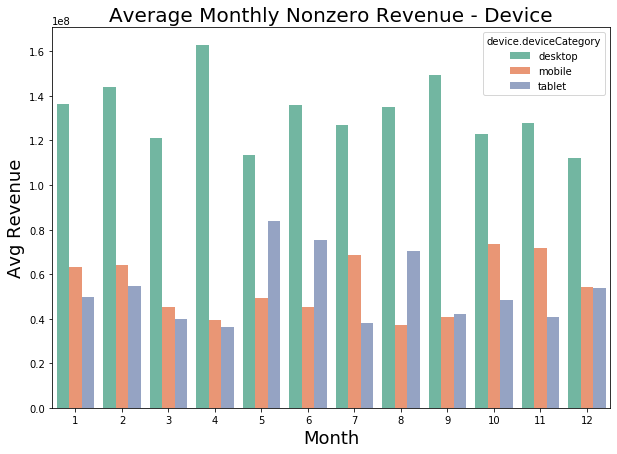

In [103]:
# Average Monthly Nonzero Revenue - Device
plt.figure(figsize=(10,7))

sns.barplot(x="month", y="totals.transactionRevenue", hue="device.deviceCategory", data=nz_revenue_df, palette='Set2', ci=None)
plt.title("Average Monthly Nonzero Revenue - Device", fontsize=20) # seting the title size
plt.xlabel("Month", fontsize=18) # seting the x label size
plt.ylabel("Avg Revenue", fontsize=18) # seting the y label size

plt.show()

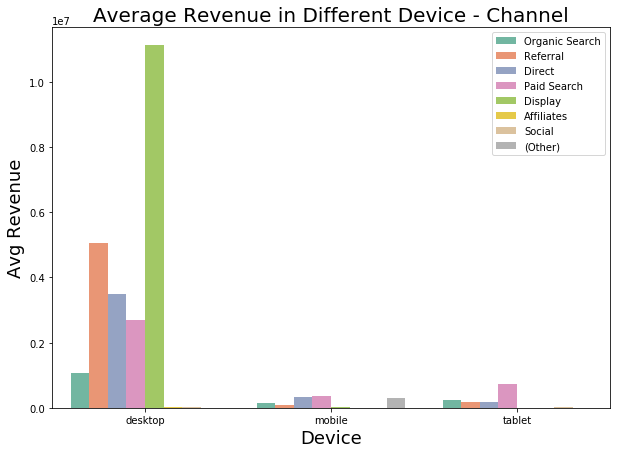

In [108]:
#Average Revenue in Different Device - Channel
plt.figure(figsize=(10,7))

sns.barplot(x="device.deviceCategory", y="totals.transactionRevenue", hue="channelGrouping", data=dataNew2, palette='Set2', ci=None)
plt.title("Average Revenue in Different Device - Channel", fontsize=20) # seting the title size
plt.xlabel("Device", fontsize=18) # seting the x label size
plt.ylabel("Avg Revenue", fontsize=18) # seting the y label size
plt.legend(loc = "upper right")

plt.show()

In [ ]:
# Average Revenue in Different Device - Channel
spark.sql("""SELECT `device.deviceCategory`, `channelGrouping`,  ROUND(AVG(`totals.transactionRevenue`), 2) as AvgRevenue
            FROM viewDF
            GROUP BY `device.deviceCategory`, `channelGrouping`
            ORDER BY AVG(`totals.transactionRevenue`) DESC, `channelGrouping`
            """).show()

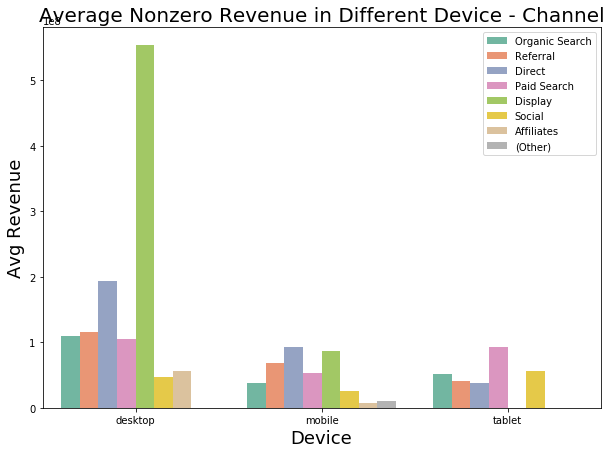

In [109]:
# Average Nonzero Revenue in Different Device - Channel
plt.figure(figsize=(10,7))

sns.barplot(x="device.deviceCategory", y="totals.transactionRevenue", hue="channelGrouping", data=nz_revenue_df, palette='Set2', ci=None)
plt.title("Average Nonzero Revenue in Different Device - Channel", fontsize=20) # seting the title size
plt.xlabel("Device", fontsize=18) # seting the x label size
plt.ylabel("Avg Revenue", fontsize=18) # seting the y label size
plt.legend(loc = "upper right")

plt.show()

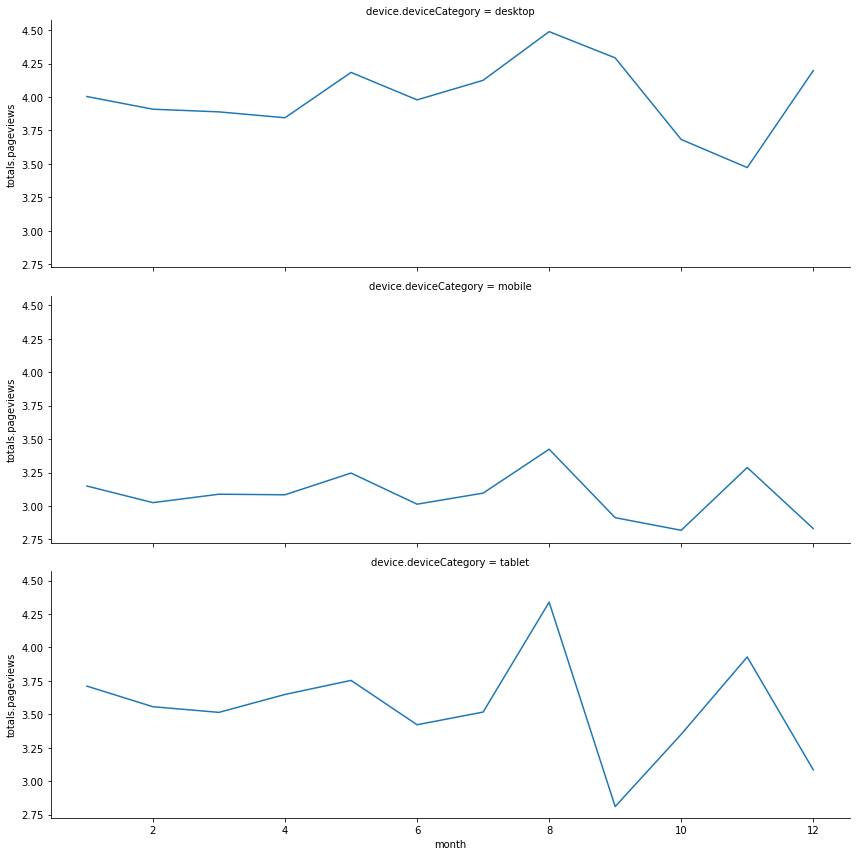

In [113]:
g = sns.FacetGrid(dataNew2, row="device.deviceCategory", height=4, aspect=3)
g = g.map(sns.lineplot, "month", "totals.pageviews", ci=None)

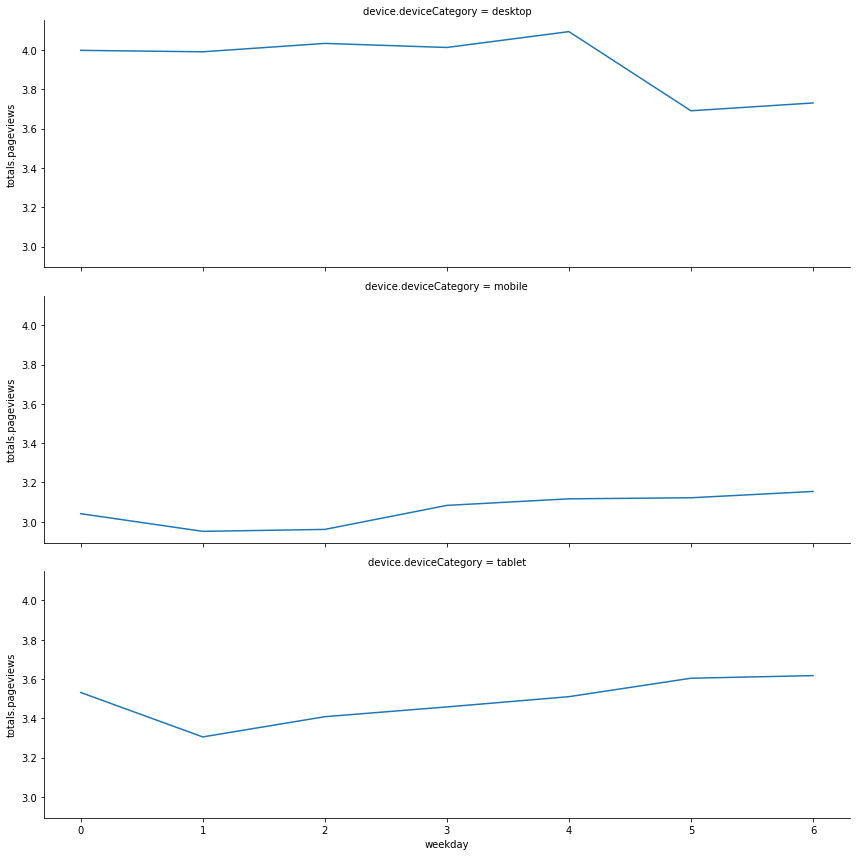

In [111]:
plt.figure(figsize=(10,7))
g = sns.FacetGrid(dataNew2, row="device.deviceCategory", height=4, aspect=3)
g = g.map(sns.lineplot, "weekday", "totals.pageviews",ci=None)

## Model

In [46]:
sc.stop()

In [47]:
spark.stop()